##Analyzer

Statistically and visually compare mRNA and lncRNA sequences from GenCode.v38.

Assume user downloaded files from GenCode38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

##Import Dependencies


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import gzip
from scipy.stats import chisquare, kstest, spearmanr
import scipy.stats as ss
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Load GenCode Data
Loads GenCode.v38 data.

Filters out mRNA sequences based on UTR check.

In [ ]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 70825
NC seqs loaded: 48752


##Process Sequences
Sampling, binning, length constraints, etc.


In [ ]:
APPLY_SUBSET = True             #Option to subset the data
MINIMUM_SEQUENCE_LENGTH = 0     #Minimum inclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = 4000  #Maximum inclusive length to filter out sequences by
SAMPLE_FRACTION = 0.5           #What fraction of the GenCode data set to take a sample of
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

In [ ]:
if APPLY_SUBSET:
  pcdf = pcdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)
  ncdf = ncdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)

  print('PC sample size:', len(pcdf))
  print('NC sample size:', len(ncdf))

PC sample size: 35412
NC sample size: 24376


In [ ]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [ ]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

if APPLY_SUBSET:
  pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
  nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

  print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
  print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (0 - 4000): 27717
NC seqs in length range (0 - 4000): 23582


##Generate Statistics


Using KmerTools to get the K-mer counts upto 3.
It returns the value in Dictionary form. (Key-Value Pair)

In [ ]:
MAX_K = 3
tool = KmerTools()
pc_counts = tool.make_dict_upto_K(MAX_K)
for sample in pc_sequences:
    tool.update_count_one_K(pc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(pc_counts,MAX_K)
print("PC counts:\n",pc_counts)
pc_freqs = tool.count_to_frequency(pc_counts,MAX_K)
print ("Frequency:\n",pc_freqs)

nc_counts = tool.make_dict_upto_K(MAX_K)
for sample in nc_sequences:
    tool.update_count_one_K(nc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(nc_counts,MAX_K)
print("NC counts:\n",nc_counts)
nc_freqs = tool.count_to_frequency(nc_counts,MAX_K)
print ("Frequency:\n",nc_freqs)

PC counts:
 {'A': 13761107, 'C': 13352571, 'G': 13663331, 'T': 12942446, 'AA': 3947355, 'AC': 2769514, 'AG': 4075931, 'AT': 2954539, 'CA': 3947355, 'CC': 3972879, 'CG': 1554746, 'CT': 3872886, 'GA': 3749965, 'GC': 3492962, 'GG': 3829259, 'GT': 2586582, 'TA': 2106910, 'TC': 3112168, 'TG': 4192472, 'TT': 3526215, 'AAA': 1298332, 'AAC': 699498, 'AAG': 1134130, 'AAT': 808944, 'ACA': 911941, 'ACC': 806918, 'ACG': 302655, 'ACT': 747111, 'AGA': 1224100, 'AGC': 1035679, 'AGG': 1072915, 'AGT': 741957, 'ATA': 558117, 'ATC': 661574, 'ATG': 933591, 'ATT': 800333, 'CAA': 907393, 'CAC': 829050, 'CAG': 1389708, 'CAT': 818320, 'CCA': 1174892, 'CCC': 1112575, 'CCG': 515080, 'CCT': 1169010, 'CGA': 317151, 'CGC': 444639, 'CGG': 515373, 'CGT': 277310, 'CTA': 510194, 'CTC': 971261, 'CTG': 1462157, 'CTT': 928158, 'GAA': 1146599, 'GAC': 730296, 'GAG': 1154664, 'GAT': 716337, 'GCA': 937833, 'GCC': 1097926, 'GCG': 452209, 'GCT': 1004003, 'GGA': 1178369, 'GGC': 1028192, 'GGG': 982805, 'GGT': 638717, 'GTA': 4253

This function takes a dictionary as a parameter. It checks the length of the key to determine if it is 1-mer, 2-mer or 3 mer and assign the values respectively. 

In [ ]:
def get_stats(dict):
  one_mer = []
  one_mer_key = []
  two_mer= []
  two_mer_key=[]
  three_mer= []
  three_mer_key=[]
  for sequence in enumerate(dict.items()):
    if(len(sequence[1][0])==1):
      one_mer.append(sequence[1][1])
      one_mer_key.append(sequence[1][0])
    if(len(sequence[1][0])==2):
      two_mer.append(sequence[1][1])
      two_mer_key.append(sequence[1][0])
    if(len(sequence[1][0])==3):
      three_mer.append(sequence[1][1])
      three_mer_key.append(sequence[1][0])
  return one_mer_key, one_mer, two_mer_key,two_mer, three_mer_key, three_mer

In [51]:
#Gets the list  of 1-mer, 2-mer and 3-mer counts along with their key
#In the order of Key-Value. 
pc_stats = get_stats(pc_freqs)
nc_stats = get_stats(nc_freqs)

#1-mer
one_mer_pc = np.asarray(pc_stats[1])
one_mer_nc = np.asarray(nc_stats[1])
#2-mer
two_mer_pc = np.asarray(pc_stats[3])
two_mer_nc = np.asarray(nc_stats[3])
#3-mer
three_mer_pc = np.asarray(pc_stats[5])
three_mer_nc = np.asarray(nc_stats[5])

#Keys that can be used as labels.
one_mer_keys = pc_stats[0]
two_mer_keys = pc_stats[2]
three_mer_keys = pc_stats[4]

print(two_mer_pc)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(one_mer_keys)
print(one_mer_pc)
print(one_mer_nc)

['A', 'C', 'G', 'T']
[0.25616617 0.24856118 0.25434605 0.24092661]
[0.27915527 0.22922435 0.22906082 0.26255956]


In [ ]:
oc = ORF_counter()

pc_max_orf_len = np.empty(1, dtype=object)
nc_max_orf_len = np.empty(1, dtype=object)
pc_max_orf_len[0] = np.zeros(len(pc_sequences))
nc_max_orf_len[0] = np.zeros(len(nc_sequences))

for i in range(len(pc_sequences)):
  oc.set_sequence(pc_sequences[i])
  pc_max_orf_len[0][i] = oc.get_max_orf_len()
for i in range(len(nc_sequences)):
  oc.set_sequence(nc_sequences[i])
  nc_max_orf_len[0][i] = oc.get_max_orf_len()

Using Correlation to see if the total length of series have any relation to the length of ORF. 

[[1.         0.71200161]
 [0.71200161 1.        ]]


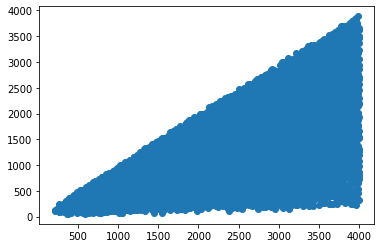

In [ ]:
tools = ORF_RE() #Uses Regular Expression from Professor Miller's RNA_describe.

total_length_of_sequence=[]
length_of_ORF=[]
for i in range(len(pc_sequences)):
  total_length_of_sequence.append(len(pc_sequences[i]))
  length_of_ORF.append(tools.get_three_lengths(pc_sequences[i])[1])
r = np.corrcoef(np.asarray(total_length_of_sequence), np.asarray(length_of_ORF))
print(r)
plt.scatter(np.asarray(total_length_of_sequence), np.asarray(length_of_ORF))
plt.show()

[[1.         0.47579954]
 [0.47579954 1.        ]]


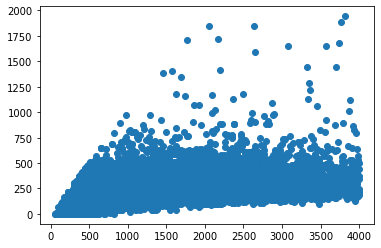

In [ ]:
total_length_of_sequence=[]
length_of_ORF=[]
for i in range(len(nc_sequences)):
  total_length_of_sequence.append(len(nc_sequences[i]))
  length_of_ORF.append(tools.get_three_lengths(nc_sequences[i])[1])
r = np.corrcoef(np.asarray(total_length_of_sequence), np.asarray(length_of_ORF))
print(r)
plt.scatter(np.asarray(total_length_of_sequence), np.asarray(length_of_ORF))
plt.show()

KS-Similarity Test
Not sure how it works but lets give it a shot. 

In [ ]:
x = kstest(two_mer_pc, "norm")
print(x)

KstestResult(statistic=0.5115505153683243, pvalue=0.00020717887792749706)


## Spearman Rank Correlation

In [40]:
list_pc = random.sample(pc_sequences,100)
list_nc = random.sample(nc_sequences, 100)
type(pc_sequences[0])



str

In [55]:
MAX_K = 6
tool = KmerTools()
kmer_pc = []
kmer_nc=[]
for sample in list_pc:
    pc_counts = tool.make_dict_upto_K(MAX_K)
    #tool.update_count_one_K(pc_counts,MAX_K,sample,True)
    #tool.harvest_counts_from_K(pc_counts,MAX_K)
    tool.update_count_one_K(pc_counts,MAX_K,sample)
    pc_freqs = tool.count_to_frequency(pc_counts,MAX_K)
    pc_vals = list(pc_freqs.values())
    kmer_pc.append(pc_vals)
#print(kmer_pc)



for sample in list_nc:
    nc_counts = tool.make_dict_upto_K(MAX_K)
    #tool.update_count_one_K(nc_counts,MAX_K,sample,True)
    #tool.harvest_counts_from_K(nc_counts,MAX_K)
    tool.update_count_one_K(nc_counts,MAX_K,sample)
    nc_freqs = tool.count_to_frequency(nc_counts,MAX_K)
    nc_vals = list(nc_freqs.values())
    kmer_nc.append(nc_vals)

count =0
while(count<1):
  #pc_stats = get_stats(kmer_pc[count])
  #nc_stats = get_stats(kmer_nc[count])
  #3-mer

  #three_mer_pc = np.asarray(pc_stats[5])
  #three_mer_nc = np.asarray(nc_stats[5])
  #print(three_mer_pc)
  #print(three_mer_nc)

  coef, p = spearmanr (kmer_pc[0],kmer_pc[1])
  coef, p = spearmanr (kmer_nc[0],kmer_nc[1])

  print(kmer_pc[0])
  print('Spearmans correlation coefficient: %.3f' % coef)
  alpha = 0.05
  #if p > alpha:
	  #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
  #else:
	  #print('Samples are correlated (reject H0) p=%.3f' % p)
  count+=1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
#Gets the list  of 1-mer, 2-mer and 3-mer counts along with their key
#In the order of Key-Value. 
pc_stats = get_stats(pc_freqs)
nc_stats = get_stats(nc_freqs)


#3-mer
three_mer_pc = np.asarray(pc_stats[5])
three_mer_nc = np.asarray(nc_stats[5])

#Keys that can be used as labels.
one_mer_keys = pc_stats[0]
two_mer_keys = pc_stats[2]
three_mer_keys = pc_stats[4]

[0.03110394 0.01453994 0.0221277  0.02015254 0.01875428 0.01303413
 0.00352009 0.01650533 0.02581402 0.01698445 0.01910629 0.0146475
 0.01400215 0.01388481 0.01797203 0.01902806 0.01832404 0.01572309
 0.02433754 0.01719957 0.02081744 0.01500929 0.00514325 0.0197223
 0.00343209 0.00438056 0.00483035 0.00335387 0.01096118 0.01798181
 0.02540334 0.02005476 0.02313484 0.01257456 0.02035788 0.01383592
 0.0164271  0.01546886 0.00414589 0.01651511 0.01999609 0.01434438
 0.01354258 0.01030605 0.00820377 0.01042339 0.01517552 0.01245722
 0.01551775 0.00898602 0.0096607  0.01370881 0.0196343  0.01717024
 0.0032072  0.02164858 0.02061211 0.01679867 0.02054366 0.01792314
 0.01477462 0.01941918 0.0173658  0.02826831]


##Results

In [ ]:
data_set_names = ['mRNA', 'lncRNA']

In [ ]:
pg = PlotGenerator()
pg.set_text_options(45, 'right', 0, 'center', 12)

In [ ]:
pg.set_text('1-Mer Frequencies', 'Mers', 'Frequency', one_mer_keys, None)
pg.bar_plot([one_mer_pc, one_mer_nc], data_set_names)

pg.set_text('2-Mer Frequencies', 'Mers', 'Frequency', two_mer_keys, None)
pg.bar_plot([two_mer_pc, two_mer_nc], data_set_names)

pg.set_figure_options(width=16)
pg.set_text_options(90, 'right', 0, 'center', 7)
pg.set_text('3-Mer Frequencies', 'Mers', 'Frequency', three_mer_keys, None)
pg.bar_plot([three_mer_pc, three_mer_nc], data_set_names)

pg.set_figure_options()
pg.set_text_options(45, 'right', 0, 'center', 12)
pg.set_text('Max ORF Lengths', 'RNA Types', 'Max ORF Length', [''], None)
pg.box_plot([pc_max_orf_len, nc_max_orf_len], data_set_names, False)